## Imports

In [14]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split,KFold
import matplotlib.pyplot as plt
import tensorflow as tf
import re

# for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
K.clear_session()

## Functions

In [2]:
# extract prefix to group by participant insted of trip
def extract_prefix(filename):
    # split filename on '_' 
    return re.split(r'_', filename)[0]

# create sequences of consecutive intrevales 
def create_sequences(data, labels, filenames, window_size):
    # vars to store the sequences and the respective labels
    sequences = []
    sequence_labels = []
    
    # get the file name to filter by participant
    current_prefix = extract_prefix(filenames[0])
    current_sequence = []
    current_labels = []
    
    # loop all intrevals
    for i in range(len(data)):
        # get current filename
        prefix = extract_prefix(filenames[i])
        
        # if the intreval belongs to diferent participant reset the sequences and vars
        if prefix != current_prefix:
            current_prefix = prefix
            current_sequence = [] 
            current_labels = []

        # add the intrevlal and the label to the current sequence
        current_sequence.append(data[i])
        current_labels.append(labels[i])
        
        # check if the sequence reach the max size and if so, store the sequence and the lable
        if len(current_sequence) == window_size:
            sequences.append(current_sequence.copy()) 
            sequence_labels.append(current_labels[-1]) 
            current_sequence.pop(0)

    return np.array(sequences), np.array(sequence_labels)

## Data Pre-Processing

In [3]:
# get data
file_path_1 = '../pre_process_2/datasets_v2/supervised_1_min.csv'
df_1_min = pd.read_csv(file_path_1, delimiter=',')

# filenames with the "pvt recording"
filenames_to_remove = [
    "fp01_2.edf", "fp01_4.edf", "fp02_1.edf", "fp02_2.edf", "fp02_4.edf",
    "fp03_1.edf", "fp03_2.edf", "fp04_1.edf", "fp05_1.edf", "fp06_1.edf",
    "fp07_1.edf", "fp08_1.edf", "fp09_1.edf", "fp10_1.edf", "fp11_1.edf",
    "fp12_1.edf", "fp13_1.edf", "fp14_1.edf", "fp14_3.edf", "fp15_1.edf",
    "fp16_1.edf", "fp17_1.edf", "fp17_2.edf", "fp17_4.edf", "fp18_1.edf",
    "fp18_2.edf", "fp19_1.edf", "fp19_3.edf", "fp19_4.edf", "fp20_1.edf", 
    "fp20_3.edf"
]

#remove the unwanted instances from the dfs
df_1_min = df_1_min[~df_1_min['Filename'].isin(filenames_to_remove)]

# remove columns with null values
df_1_min = df_1_min[(df_1_min.columns.difference(['HRV_SDANN1','HRV_SDNNI1','HRV_SDANN2','HRV_SDNNI2','HRV_SDANN5','HRV_SDNNI5','HRV_ULF','HRV_VLF'], sort=False))]

# remove missing values
df_1_min = df_1_min.dropna()

# get wanted features for training data
df_features_1_min = df_1_min[(df_1_min.columns.difference(['Interval_Start', 'Interval_End', 'Filename', 'kss_answer'], sort=False))]

# final wanted features
features_1_min = df_features_1_min.columns.to_list()

### Normalization

In [4]:
# Normalize data
scaler = StandardScaler()
X_scaled_1_min = scaler.fit_transform(df_1_min[features_1_min].values)

### Descretrization

In [5]:
# descretize the value of KSS
labels_1_min = (df_1_min['kss_answer'] > 6).astype(int)

### Prepare data to train the model

In [6]:
# get all filenames
filenames_1_min = df_1_min['Filename'].values

# number of intrevlas in sequence
window_size = 4 

# create sequences and respective lables
X_sequences_1_min, y_sequences_1_min = create_sequences(X_scaled_1_min, labels_1_min.values, filenames_1_min, window_size)

# Verify shape of sequences
print("Shape of X_sequences of 1 Min :", X_sequences_1_min.shape)
print("Shape of y_sequences of 1 Min:", X_sequences_1_min.shape)

# test and train data split
X_train_1_min, X_test_1_min, y_train_1_min, y_test_1_min = train_test_split(X_sequences_1_min, y_sequences_1_min, test_size=0.20, random_state=42)

Shape of X_sequences of 1 Min : (4289, 4, 27)
Shape of y_sequences of 1 Min: (4289, 4, 27)


### Create LSTM Model

In [ ]:
# K-Fold setup
kf = KFold(n_splits=5, shuffle=True, random_state=42) 

# to store metrics and history for each fold
fold_histories = []
roc_data = []  
cms = []  

# to store metrics for each fold
accuracies = []
precisions = []
recalls = []
f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(X_sequences_1_min)):
    print(f"\nFold {fold + 1}")
    
    # train and validation split
    X_train_fold, X_val_fold = X_sequences_1_min[train_index], X_sequences_1_min[val_index]
    y_train_fold, y_val_fold = y_sequences_1_min[train_index], y_sequences_1_min[val_index]

    # define the LSTM model
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(32, input_shape=(X_train_fold.shape[1], X_train_fold.shape[2]), return_sequences=False),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # train
    history = model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=32, validation_data=(X_val_fold, y_val_fold), verbose=0)
    fold_histories.append(history)
    
    # predict on validation set
    y_pred = model.predict(X_val_fold)
    y_pred_binary = (y_pred > 0.5).astype(int).reshape(-1)  
    
    # get ROC curve 
    fpr, tpr, _ = roc_curve(y_val_fold, y_pred)
    roc_data.append((fpr, tpr))
    
    # save cm
    cms.append(confusion_matrix(y_val_fold, y_pred_binary))
    
    # get metrics
    accuracy = accuracy_score(y_val_fold, y_pred_binary)
    precision = precision_score(y_val_fold, y_pred_binary)
    recall = recall_score(y_val_fold, y_pred_binary)
    f1 = f1_score(y_val_fold, y_pred_binary)

    # store metrics
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)


# print average metrics
print("\nAverage Metrics across all folds:")
print(f'  Accuracy: {np.mean(accuracies):.3f}')
print(f'  Precision: {np.mean(precisions):.3f}')
print(f'  Recall: {np.mean(recalls):.3f}')
print(f'  F1 Score: {np.mean(f1_scores):.3f}')


Fold 1


c:\Users\duart\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 2


c:\Users\duart\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 3


c:\Users\duart\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 4


c:\Users\duart\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 5


c:\Users\duart\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Average Metrics across all folds:
  Accuracy: 0.860
  Precision: 0.858
  Recall: 0.840
  F1 Score: 0.849


### Evaluation and Visualization

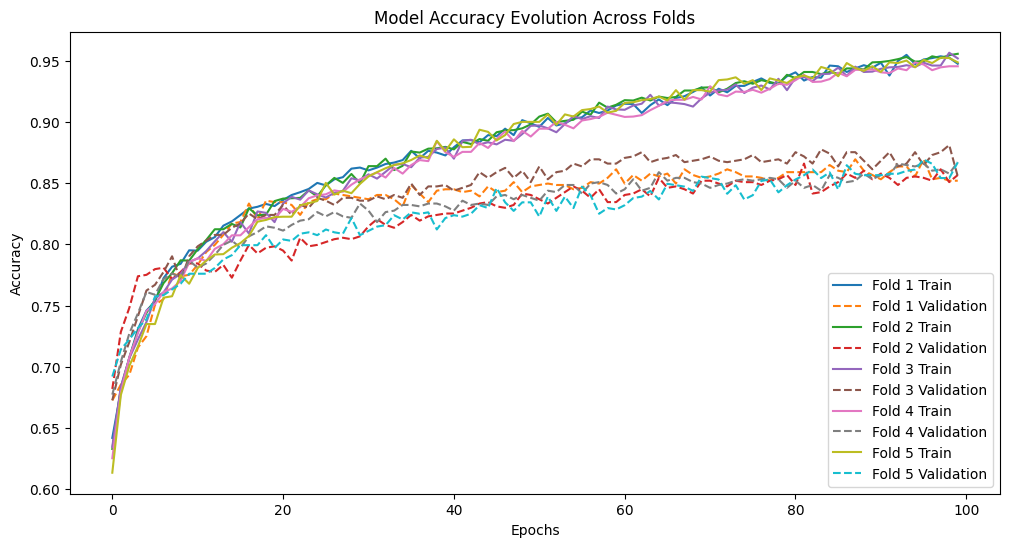

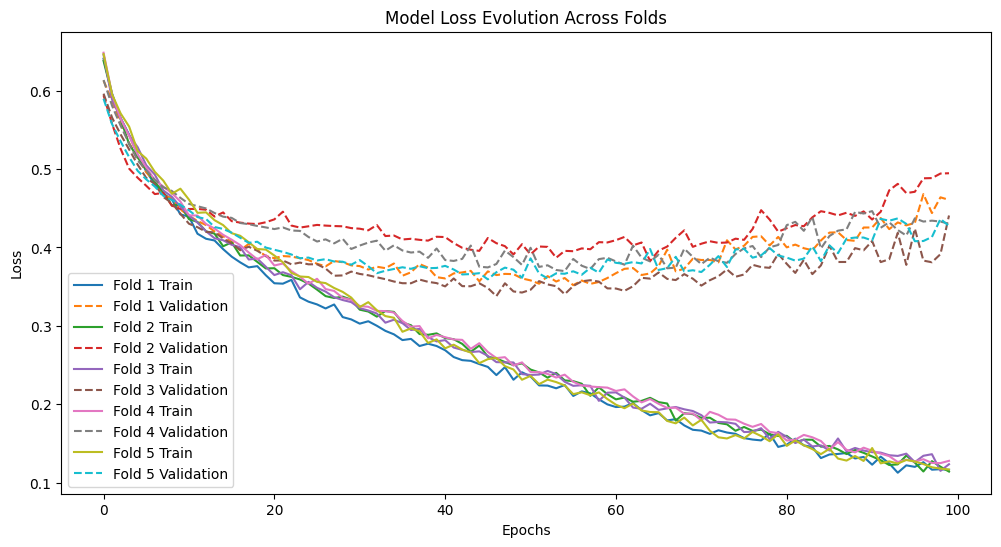

In [ ]:
# plot loss and accuracy
plt.figure(figsize=(12, 6))
for i, history in enumerate(fold_histories):
    # plot accuracy
    plt.plot(history.history['accuracy'], label=f'Fold {i+1} Train')
    plt.plot(history.history['val_accuracy'], linestyle='--', label=f'Fold {i+1} Validation')
plt.title('Model Accuracy Evolution Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(12, 6))
for i, history in enumerate(fold_histories):
    # plot loss
    plt.plot(history.history['loss'], label=f'Fold {i+1} Train')
    plt.plot(history.history['val_loss'], linestyle='--', label=f'Fold {i+1} Validation')
plt.title('Model Loss Evolution Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

## Models Predictions

### ROC Curve

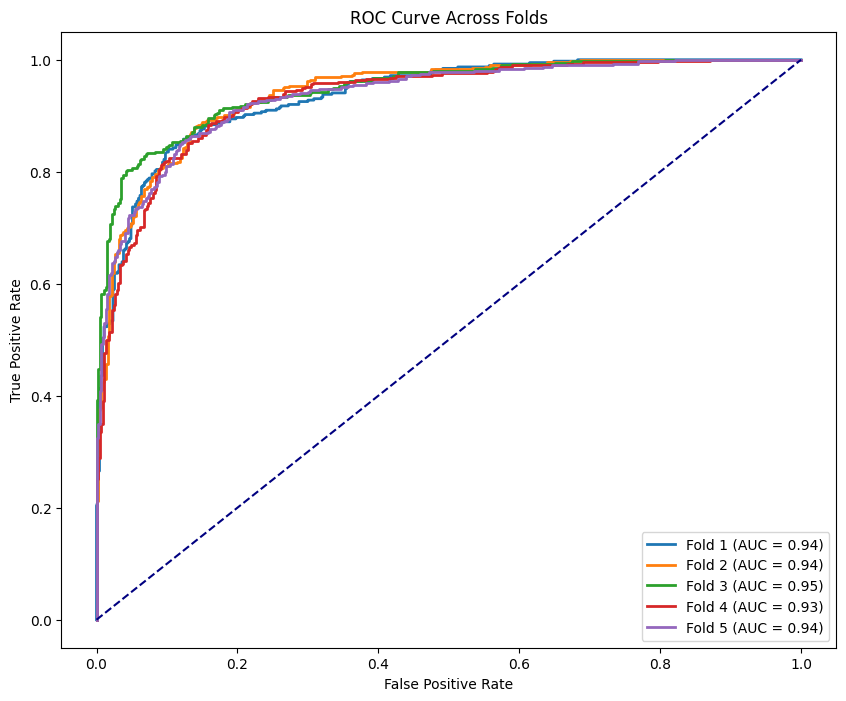

In [ ]:
# ROC curves
plt.figure(figsize=(10, 8))
for i, (fpr, tpr) in enumerate(roc_data):
    plt.plot(fpr, tpr, lw=2, label=f'Fold {i+1} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Across Folds')
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix

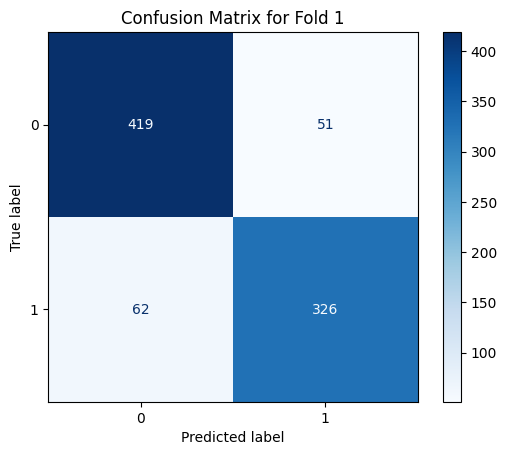

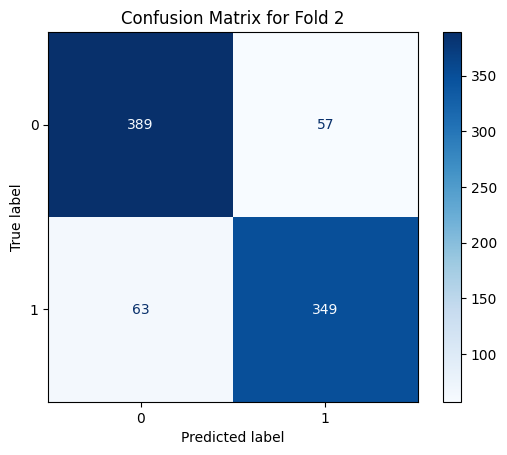

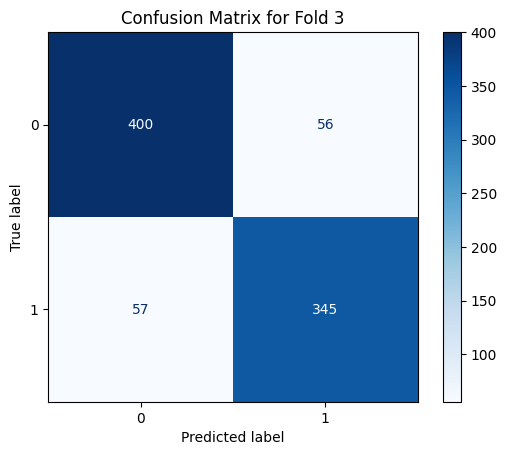

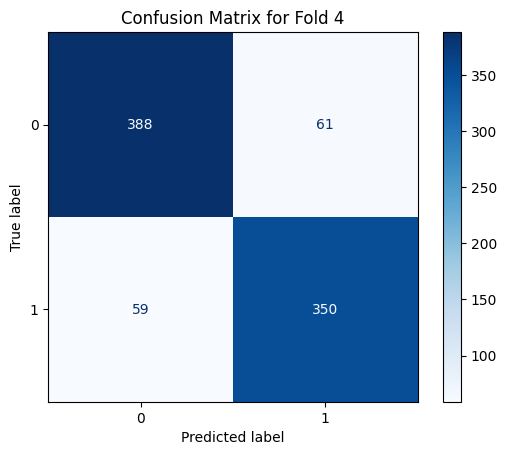

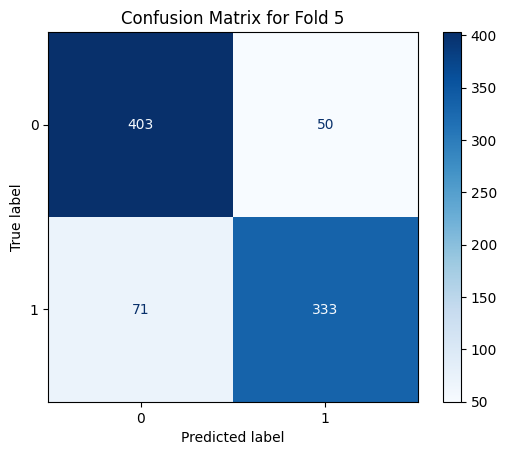

In [13]:
# Plot Confusion Matrices
for i, cm in enumerate(cms):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for Fold {i+1}')
    plt.show()